## Import Premier League, League 1, La Liga Data and perform basic cleaning

In [58]:
import numpy as np
import pandas as pd
from pathlib import Path

# Resolve data directory relative to the notebook location (../data)
data_dir = (Path.cwd().parent / "data").resolve()
processed_dir = data_dir / "processed"

# Helper to choose processed file first, else fallback raw by league code
def resolve_league_path(league_code: str) -> str:
    processed_file = processed_dir / f"{league_code}_combined.csv"
    raw_fallback = {
        "ENG": data_dir / "premier_league_matches.csv",
        "FRA": data_dir / "league1_matches.csv",
        "SPA": data_dir / "la_liga_matches.csv",
    }.get(league_code)

    if processed_file.exists():
        return str(processed_file)
    if raw_fallback and raw_fallback.exists():
        return str(raw_fallback)
    raise FileNotFoundError(
        f"Data file not found for {league_code}. Expected: {processed_file} or {raw_fallback}.\n"
        f"Run merge_datasets.py to create processed files."
    )

# Load all requested leagues
leagues = ["ENG", "FRA", "SPA"]
league_dfs = {}
for code in leagues:
    path = resolve_league_path(code)
    df = pd.read_csv(path)
    df = df[df["Minute"] > 0]
    league_dfs[code] = df

# Unpack for convenience
premier_league_df = league_dfs["ENG"]
league1_df = league_dfs["FRA"]
laliga_df = league_dfs["SPA"]

print("Loaded leagues:", ", ".join(league_dfs.keys()))
print(f"ENG columns: {premier_league_df.columns.tolist()}")
print(f"FRA columns: {league1_df.columns.tolist()}")
print(f"SPA columns: {laliga_df.columns.tolist()}")

Loaded leagues: ENG, FRA, SPA
ENG columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']
FRA columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']
SPA columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']


## Descriptive Statistics Analysis

In [59]:
def create_descriptive_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create descriptive statistics for match game data.

    Parameters:
    df (pd.DataFrame): DataFrame containing match game statistics.

    Returns:
    pd.DataFrame: Descriptive statistics excluding count and RBallID.
    """
    stats = {
    "goals": (df["Incident"] == "GOAL1") | (df["Incident"] == "GOAL2"),
    "corners": (df["Incident"] == "CR1") | (df["Incident"] == "CR2"),
    "shots_on_target": (df['Incident'] == 'SHG1') | (df['Incident'] == 'SHG2'),
    "fouls": (df['Incident'] == 'F1') | (df['Incident'] == 'F2'),
    "offsides": (df['Incident'] == 'O1') | (df['Incident'] == 'O2'),
    "penalties": (df['Incident'] == 'PEN1') | (df['Incident'] == 'PEN2'),
    "shots_blocked": (df['Incident'] == 'BLOCKED1') | (df['Incident'] == 'BLOCKED2'),
    "goal_kicks": (df['Incident'] == 'GK1') | (df['Incident'] == 'GK2'),
    "shots_off_target": (df['Incident'] == 'SHB1') | (df['Incident'] == 'SHB2'),
    "throwins": (df['Incident'] == 'TI1') | (df['Incident'] == 'TI2'),
    "shots_woodwork": (df['Incident'] == 'SHW1') | (df['Incident'] == 'SHW2'),
    }
    
    for name, mask in stats.items():
        df[name] = mask
    agg_cols = list(stats.keys())

    match_game = (
        df.groupby("RBallID")[agg_cols].
        sum().
        reset_index()
    )
    match_game["total_incidents"] = df.groupby("RBallID").size().values
    match_game["offensive_incidents"] = match_game["goals"] + match_game["shots_on_target"] + match_game["shots_off_target"] + match_game["shots_woodwork"] + match_game["penalties"] + match_game["corners"] + match_game["offsides"] + match_game["shots_blocked"]
    match_game["defensive_incidents"] = match_game["fouls"] + match_game["goal_kicks"] + match_game["throwins"]

    desc = match_game.describe().drop(index="count").drop(columns="RBallID").round(2)
    return desc,match_game

df1 = premier_league_df.copy()
df2 = league1_df.copy()
df3 = laliga_df.copy()
stats_premier, match_premier = create_descriptive_stats(df1)
stats_league1, match_league1 = create_descriptive_stats(df2)
stats_laliga, match_laliga = create_descriptive_stats(df3)


In [64]:
print("Premier League Descriptive Statistics:\n", stats_premier)

Premier League Descriptive Statistics:
       goals  corners  shots_on_target  fouls  offsides  penalties  \
mean   3.00    10.46             7.05  20.06      3.93       0.24   
std    1.66     3.37             3.12   5.01      2.31       0.49   
min    0.00     2.00             0.00   4.00      0.00       0.00   
25%    2.00     8.00             5.00  17.00      2.00       0.00   
50%    3.00    10.00             7.00  20.00      4.00       0.00   
75%    4.00    13.00             9.00  23.00      5.00       0.00   
max    9.00    21.00            25.00  36.00     13.00       3.00   

      shots_blocked  goal_kicks  shots_off_target  throwins  shots_woodwork  \
mean           3.63       15.78              9.24     44.58            0.49   
std            2.31        3.87              3.16      9.78            0.69   
min            0.00        4.00              1.00     13.00            0.00   
25%            2.00       13.00              7.00     38.00            0.00   
50%         

In [62]:
print("\nLeague 1 Descriptive Statistics:\n", stats_league1)

League 1 Descriptive Statistics:
       goals  corners  shots_on_target  fouls  offsides  penalties  \
mean   2.87     9.73             7.22  25.50      3.36       0.36   
std    1.67     3.32             3.10   5.66      2.15       0.59   
min    0.00     2.00             0.00   1.00      0.00       0.00   
25%    2.00     7.00             5.00  22.00      2.00       0.00   
50%    3.00     9.00             7.00  25.00      3.00       0.00   
75%    4.00    12.00             9.00  29.00      5.00       1.00   
max    9.00    23.00            18.00  47.00     12.00       4.00   

      shots_blocked  goal_kicks  shots_off_target  throwins  shots_woodwork  \
mean           2.82       16.19              9.99     45.53            0.56   
std            2.07        3.77              3.28     10.01            0.77   
min            0.00        3.00              1.00     13.00            0.00   
25%            1.00       14.00              8.00     38.00            0.00   
50%            3.0

In [66]:
print("La Liga Descriptive Statistics:\n", stats_laliga)


La Liga Descriptive Statistics:
       goals  corners  shots_on_target  fouls  offsides  penalties  \
mean   2.98     9.72             7.24  26.78      4.52       0.35   
std    1.83     3.25             3.12   5.92      2.63       0.60   
min    0.00     1.00             1.00  11.00      0.00       0.00   
25%    2.00     7.00             5.00  23.00      3.00       0.00   
50%    3.00    10.00             7.00  26.00      4.00       0.00   
75%    4.00    12.00             9.00  30.50      6.00       1.00   
max   10.00    20.00            19.00  50.00     17.00       3.00   

      shots_blocked  goal_kicks  shots_off_target  throwins  shots_woodwork  \
mean           2.76       16.07              9.95     42.38             0.6   
std            1.88        4.08              3.69      9.94             0.8   
min            0.00        4.00              1.00     18.00             0.0   
25%            1.00       13.00              8.00     35.00             0.0   
50%            2.00

# Explore correlation between statistics in each league

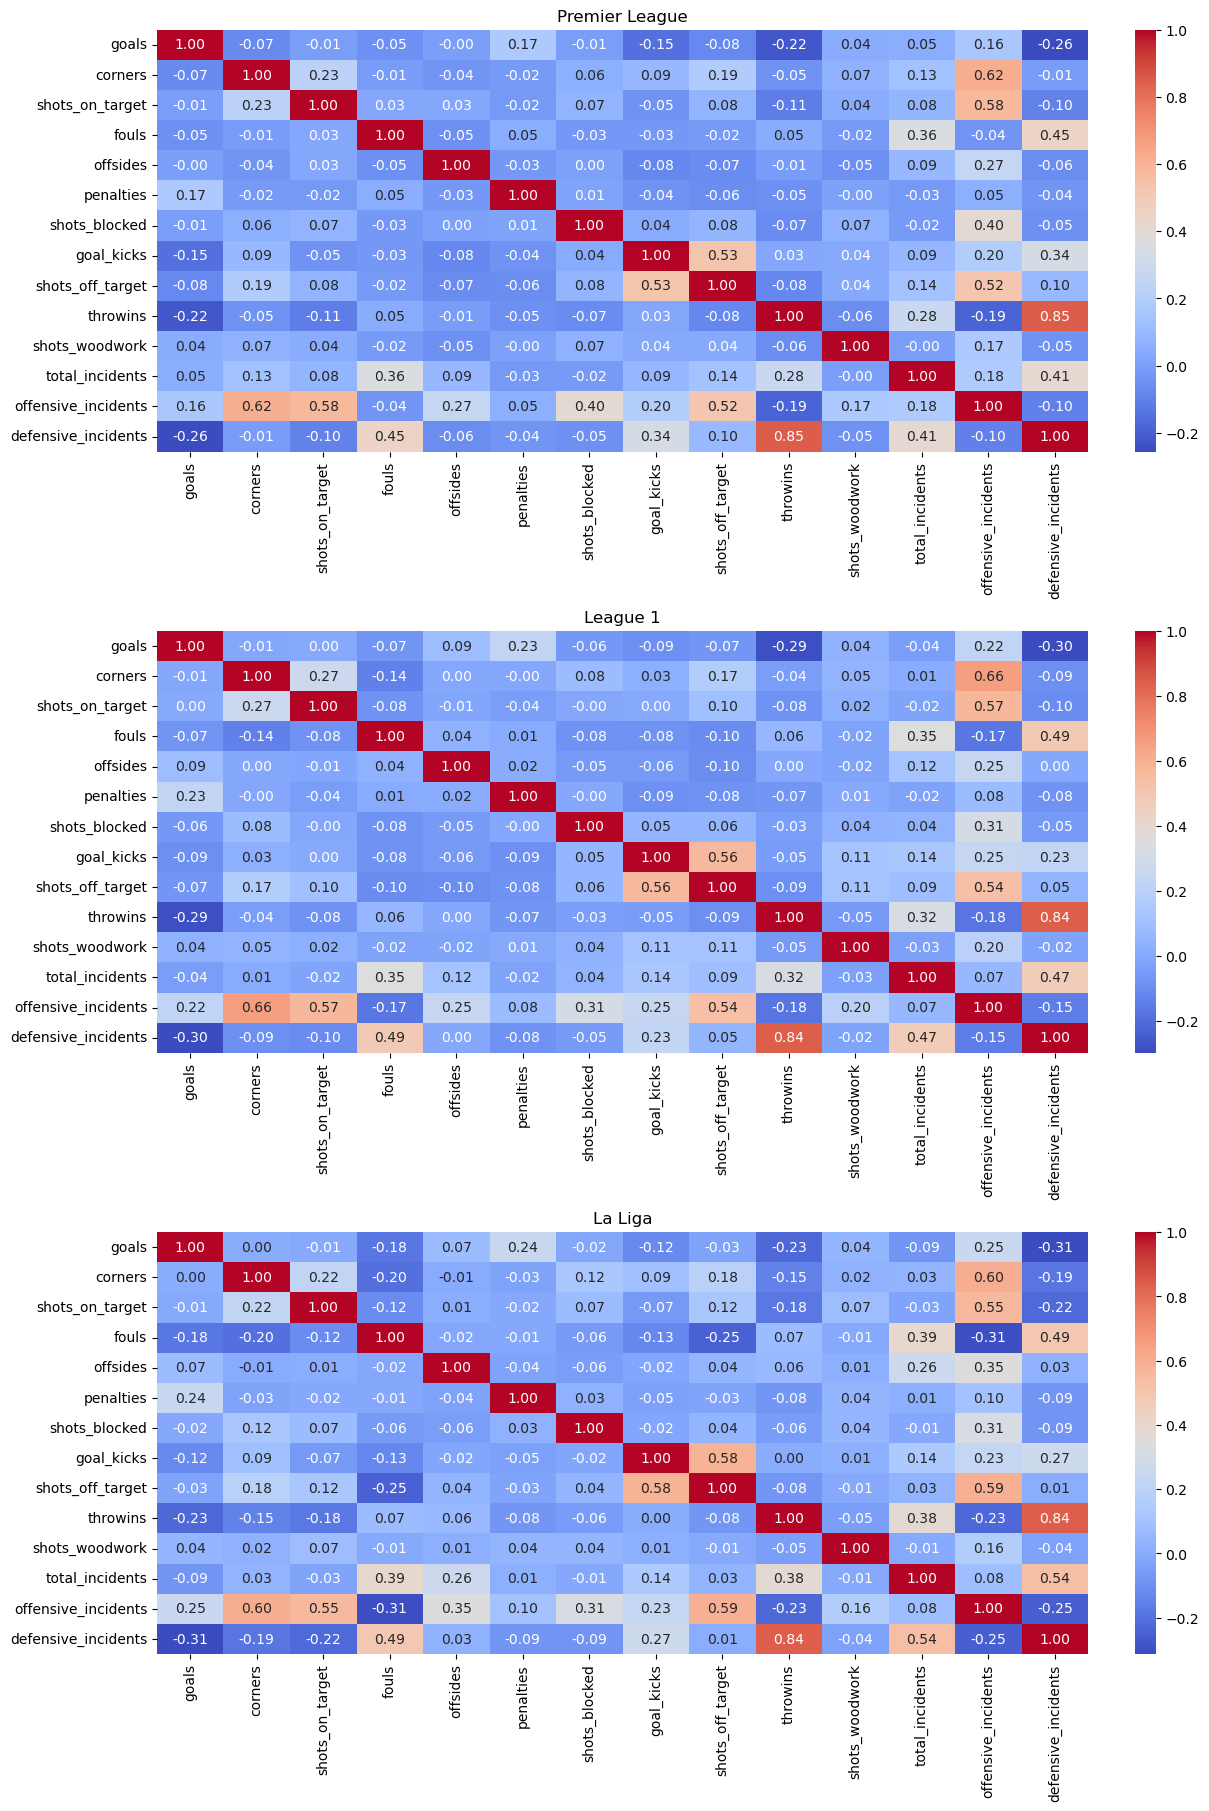

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]

fig, axes = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)
for ax, league_df, title in zip(axes, leagues, labels):
    corr = league_df.drop(columns="RBallID").corr()
    sns.heatmap(corr, ax=ax, annot=True, fmt=".2f", cmap="coolwarm")
    ax.set_title(title)

plt.show()

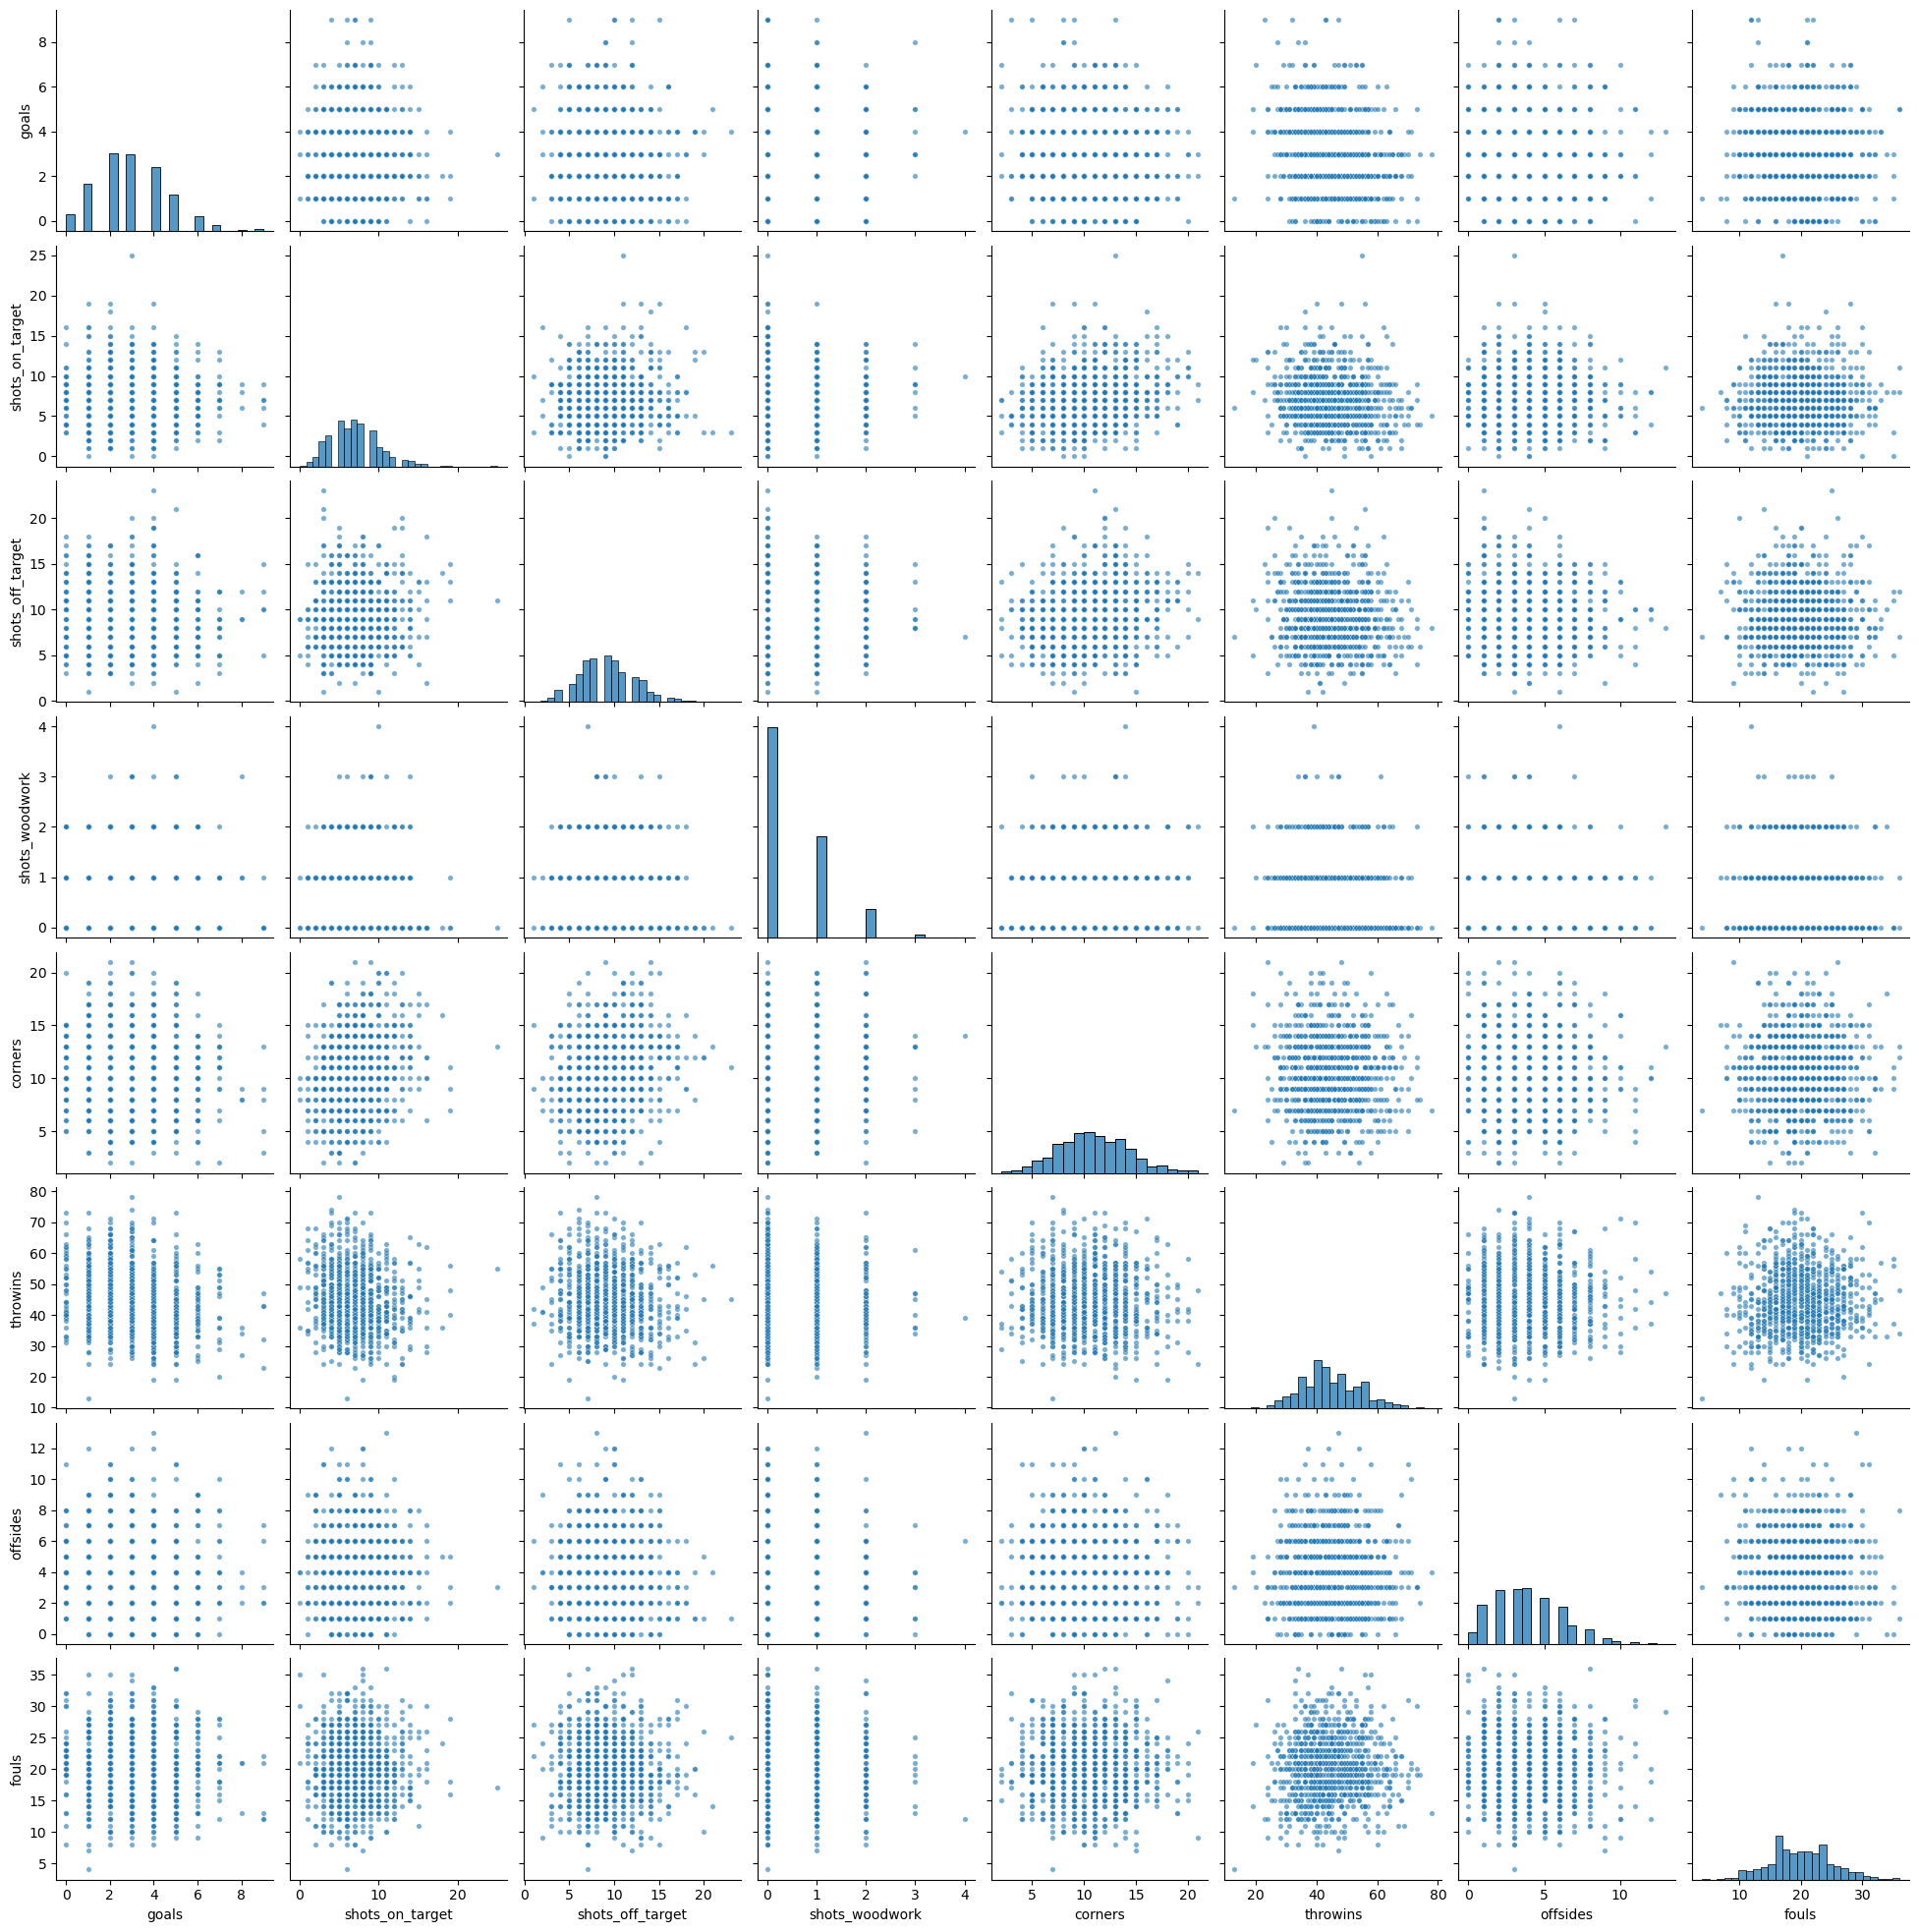

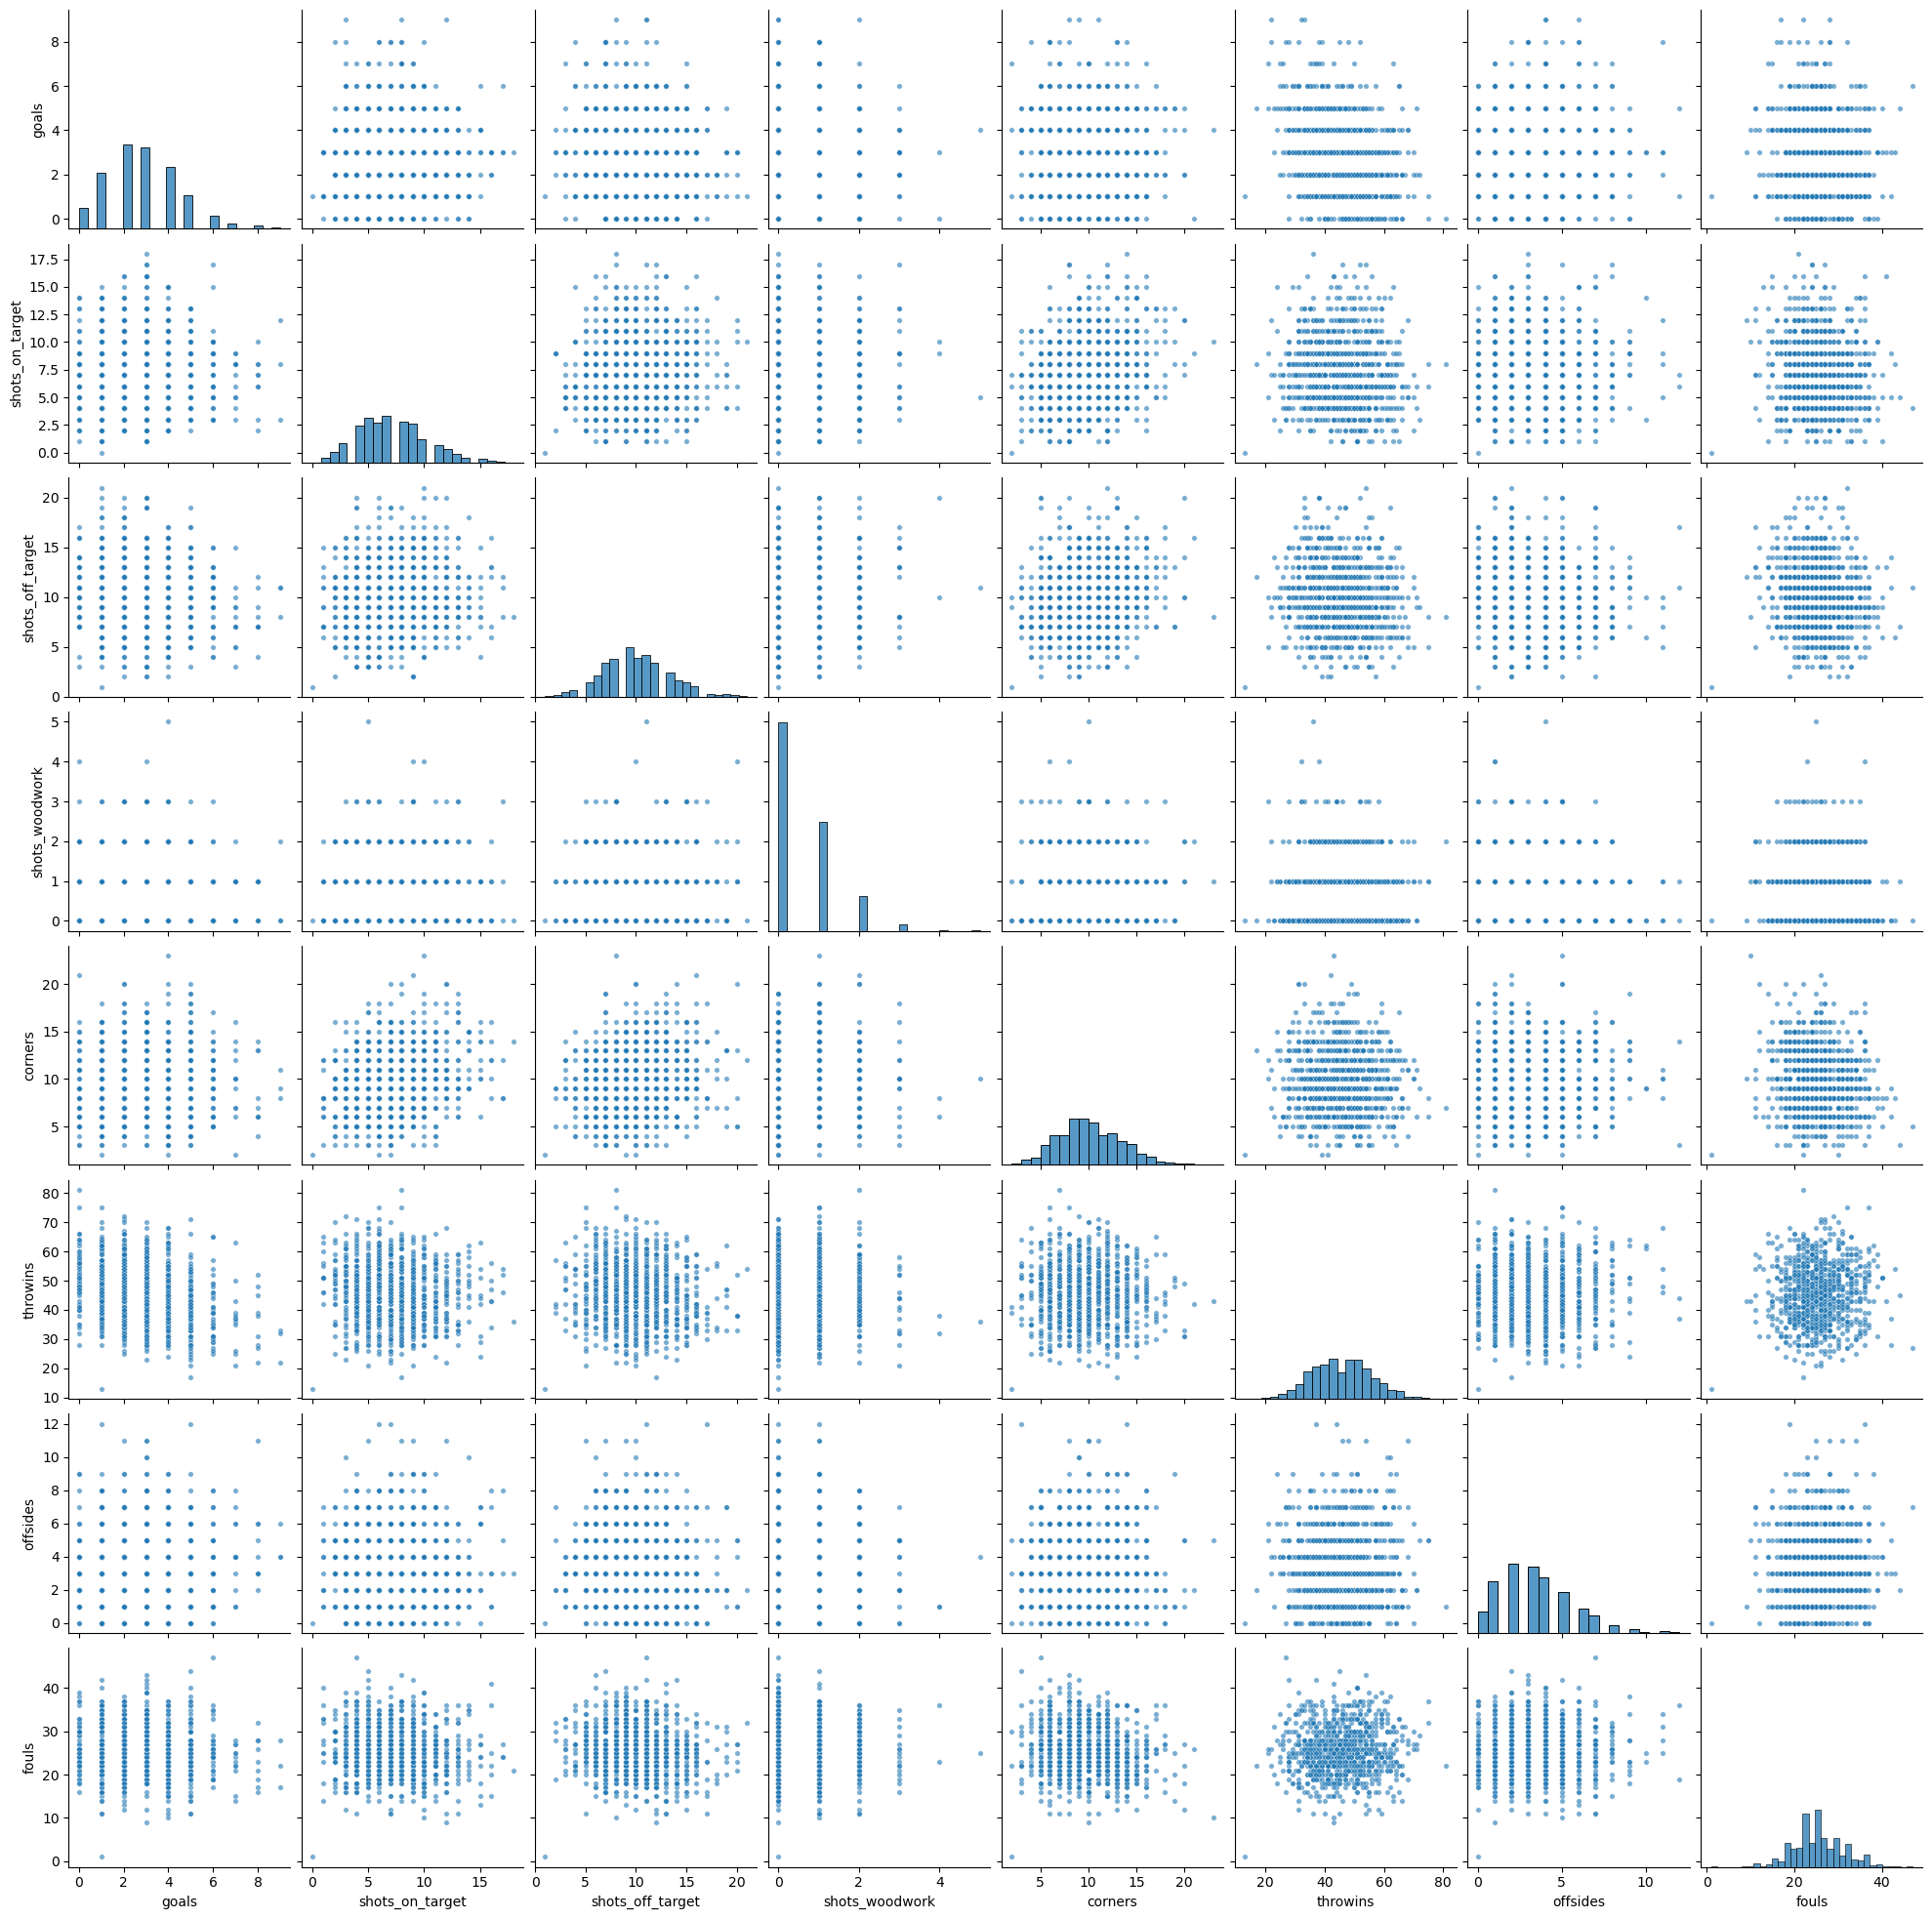

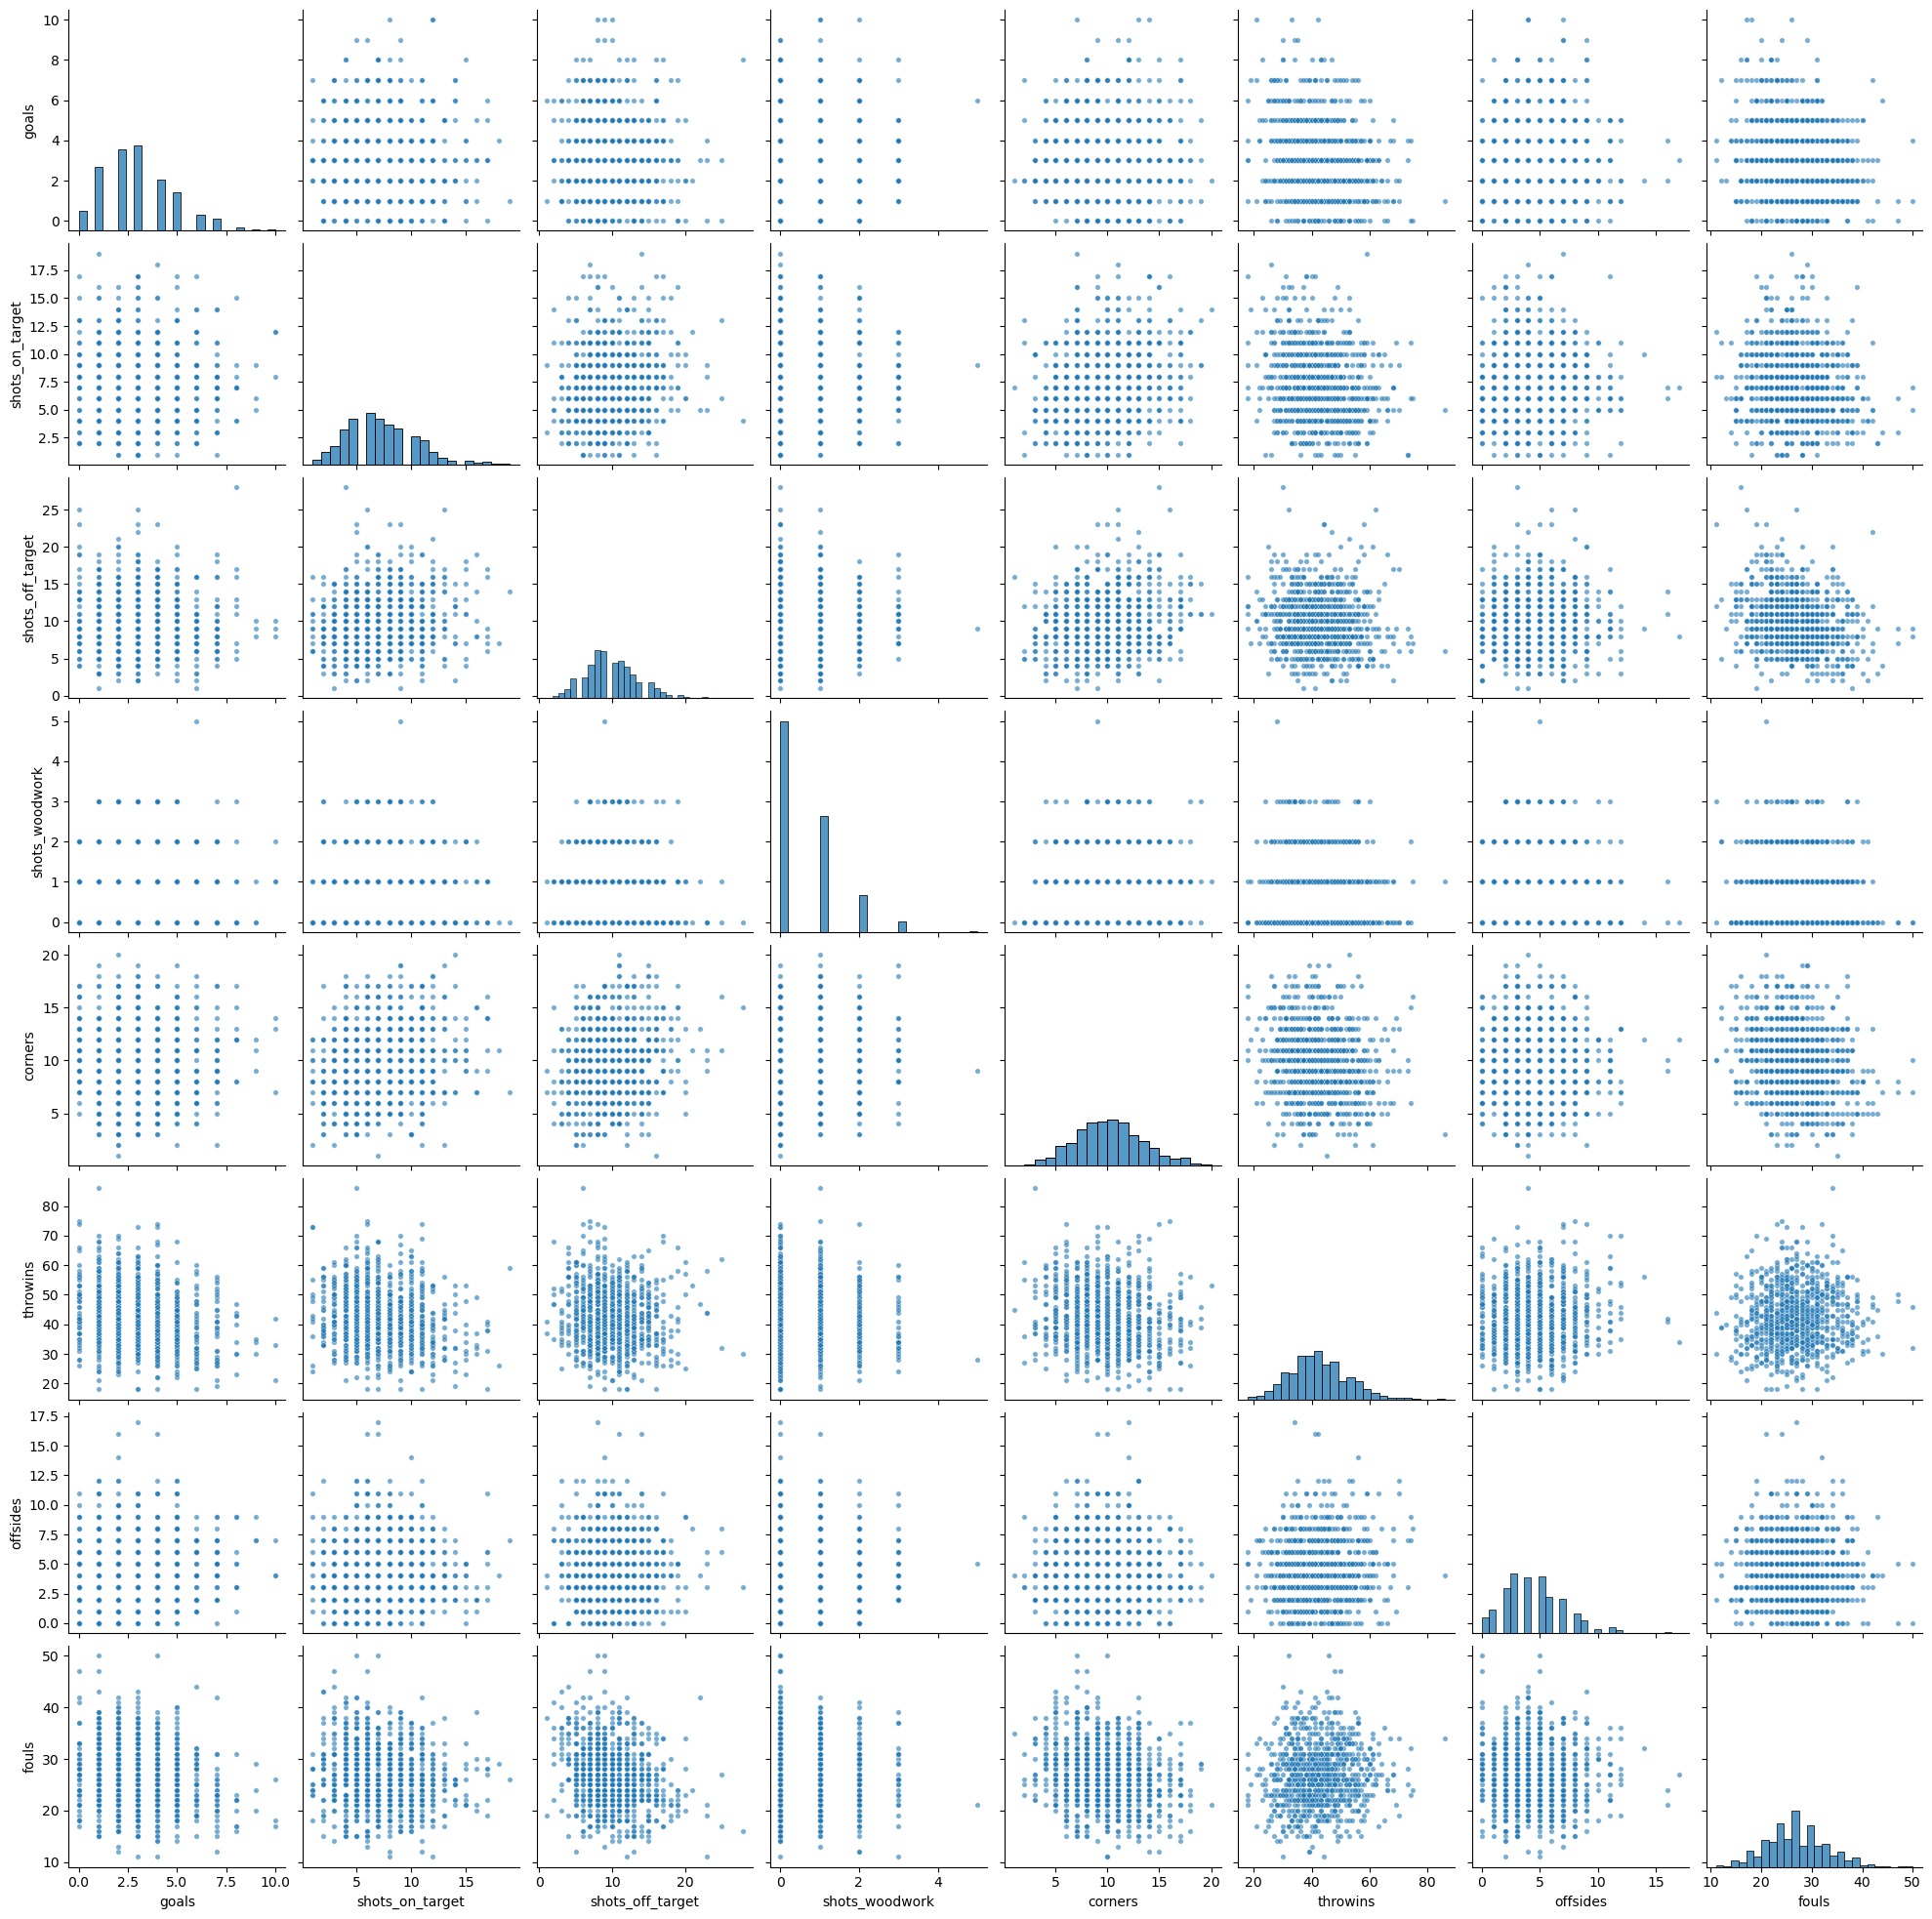

In [86]:
cols = ['goals', 'shots_on_target', 'shots_off_target', 'shots_woodwork', 'corners', 'throwins', 'offsides', 'fouls']

sns.pairplot(match_premier[cols], corner=False, plot_kws={"s": 15, "alpha": 0.6})
sns.pairplot(match_league1[cols], corner=False, plot_kws={"s": 15, "alpha": 0.6})
sns.pairplot(match_laliga[cols], corner=False, plot_kws={"s": 15, "alpha": 0.6})

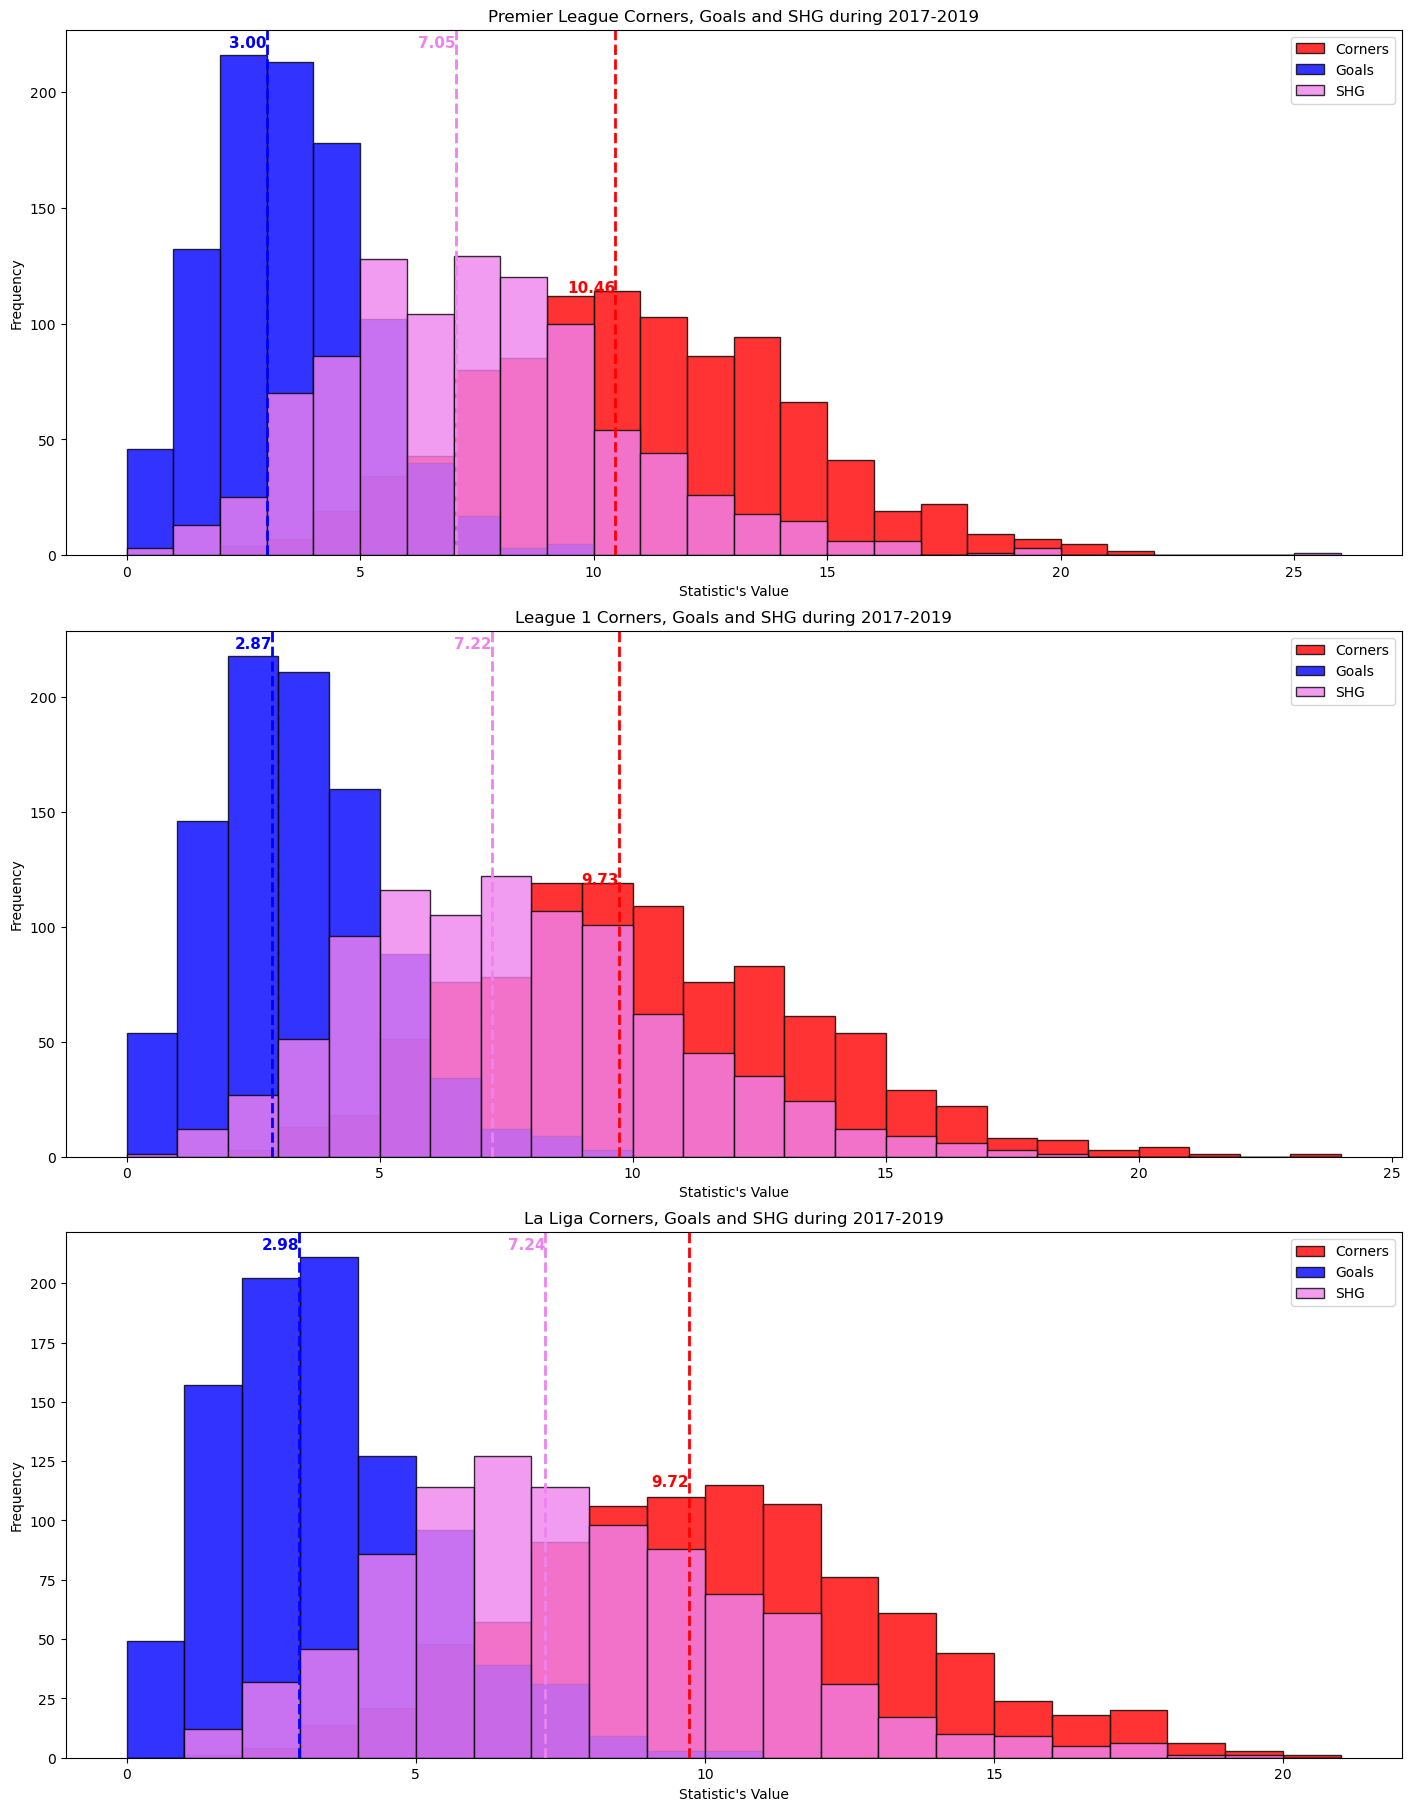

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Overlay histograms for three stats with mean lines per league (3x1)
leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]
plot_cols = {
    "corners": {"color": "red"},
    "goals": {"color": "blue"},
    "shots_on_target": {"color": "violet"},  # SHG
}

fig, axes = plt.subplots(3, 1, figsize=(14, 18), constrained_layout=True)

for ax, league_df, title in zip(axes, leagues, labels):
    # Compute common bin edges based on all selected columns to align bars
    data_min = min(league_df[c].min() for c in plot_cols.keys())
    data_max = max(league_df[c].max() for c in plot_cols.keys())
    # Use integer bins from min to max; adjust step if distribution is sparse/dense
    bins = np.arange(int(data_min), int(data_max) + 2)  # +2 so last bin includes max

    # Plot histograms
    for col, style in plot_cols.items():
        ax.hist(
            league_df[col],
            bins=bins,
            alpha=0.8,
            label=col.replace("_", " ").title() if col != "shots_on_target" else "SHG",
            color=style["color"],
            edgecolor="black",
        )

        # Mean lines and labels
        mean_val = league_df[col].mean()
        ax.axvline(mean_val, color=style["color"], linestyle="--", linewidth=2)
        # Place a text label slightly above the tallest bar; fallback y if empty
        y_max = ax.get_ylim()[1]
        ax.text(
            mean_val,
            y_max * 0.99,
            f"{mean_val:.2f}",
            color=style["color"],
            ha="right",
            va="top",
            fontsize=11,
            fontweight="bold",
        )

    ax.set_title(f"{title} Corners, Goals and SHG during 2017-2019")
    ax.set_xlabel("Statistic's Value")
    ax.set_ylabel("Frequency")
    ax.legend(loc="upper right")

plt.show()


# Check what distribution best follows our data (e.g corners, throw ins, goals) for variation purposes

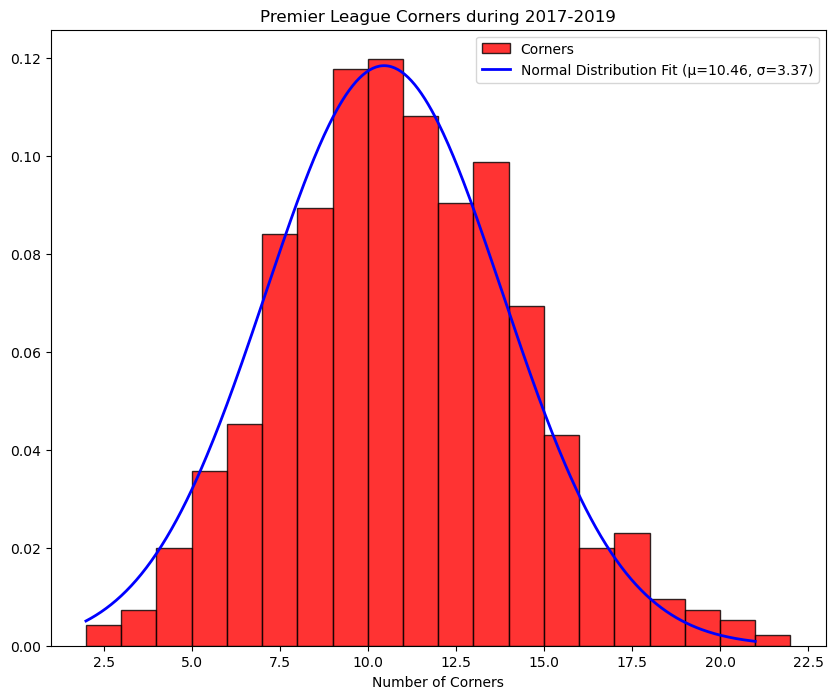

In [114]:
from scipy.stats import norm
import math

def normal_pdf(x, mu, sigma):
    return (1.0 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_gaussian_fit(series, ax, color_curve = "black", label_curve="Normal fit"):
    x = pd.to_numeric(series, errors='coerce').dropna().values
    if x.size == 0:
        return # No data to fit
    mu = x.mean()
    sigma = x.std()

    if sigma == 0:
        return  # Avoid division by zero
    x_min, x_max = x.min(), x.max()
    x_values = np.linspace(x_min, x_max, 400)
    y_values = norm.pdf(x_values, mu, sigma)
    ax.plot(x_values, y_values, color=color_curve, linewidth=2, label=f"{label_curve} (μ={mu:.2f}, σ={sigma:.2f})")


plt.figure(figsize=(10, 8))


min_data = int(match_premier.corners.min())
max_data = int(match_premier.corners.max())
bins = np.arange(min_data, max_data + 2)  # +2 to include max in last bin
plt.hist(
    match_premier.corners,
    bins=bins,
    alpha=0.8,
    label="Corners",
    color="red",
    edgecolor="black",
    density=True  # use density=True to normalize the histogram
)
plot_gaussian_fit(match_premier.corners, plt.gca(), color_curve="blue", label_curve="Normal Distribution Fit")
plt.title("Premier League Corners during 2017-2019")
plt.xlabel("Number of Corners")
plt.legend()
plt.show()

## Distribution build functions

In [ ]:
from scipy.stats import poisson, nbinom, norm, binom, lognorm
# --- Binomial PMF ---
def binomial_pmf(k_vals, n, p):
    k_vals = np.asarray(k_vals, dtype=int)
    return binom.pmf(k_vals, n=n, p=p)

# --- Estimate Binomial parameters ---
def estimate_binomial_params(x):
    n = int(x.max())  # max number of trials (can tweak)
    if n == 0:
        n = 1
    p = np.mean(x) / n
    p = min(max(p, 1e-6), 1-1e-6)  # ensure 0 < p < 1
    return n, p
# --- PMF/PDF functions ---
def plot_gaussian_fit(series, ax, color_curve = "black", label_curve="Normal fit"):
    x = pd.to_numeric(series, errors='coerce').dropna().values
    if x.size == 0:
        return # No data to fit
    mu = x.mean()
    sigma = x.std()

    if sigma == 0:
        return  # Avoid division by zero
    x_min, x_max = x.min(), x.max()
    x_values = np.linspace(x_min, x_max, 400)
    y_values = norm.pdf(x_values, mu, sigma)
    ax.plot(x_values, y_values, color=color_curve, linewidth=2, label=f"{label_curve} (μ={mu:.2f}, σ={sigma:.2f})")

def poisson_pmf(k_vals, lam):
    k_vals = np.asarray(k_vals, dtype=int)
    return poisson.pmf(k_vals, mu=lam)


def negbinom_pmf(k_vals, r, p):
    k_vals = np.asarray(k_vals, dtype=int)
    return nbinom.pmf(k_vals, n=r, p=p)


def gaussian_mixture_pdf(x_vals, w, mu1, sigma1, mu2, sigma2):
    return w * norm.pdf(x_vals, mu1, sigma1) + (1 - w) * norm.pdf(x_vals, mu2, sigma2)

# Log-normal PDF and parameter estimation (SciPy)
from scipy.stats import lognorm

def estimate_lognormal_params(x):
    # Fit log-normal via MLE: returns shape (sigma), loc, scale
    # We constrain loc=0 for count data; handle zeros by shifting or filtering
    x = np.asarray(x, dtype=float)
    x = x[x > 0]  # log-normal defined for x>0
    if x.size < 2:
        return None
    shape, loc, scale = lognorm.fit(x, floc=0)  # fix loc=0
    return shape, scale

def lognormal_pdf(x_vals, shape, scale):
    return lognorm.pdf(x_vals, s=shape, scale=scale)

# --- Parameter estimation helpers ---

def estimate_poisson_lambda(x):
    return float(np.mean(x))


def estimate_negbinom_params(x):
    m = float(np.mean(x))
    v = float(np.var(x, ddof=0))
    if v <= m or m == 0:
        r = 10.0
        p = r / (r + max(m, 1e-6))
    else:
        r = (m * m) / (v - m)
        p = r / (r + m)
    return r, p

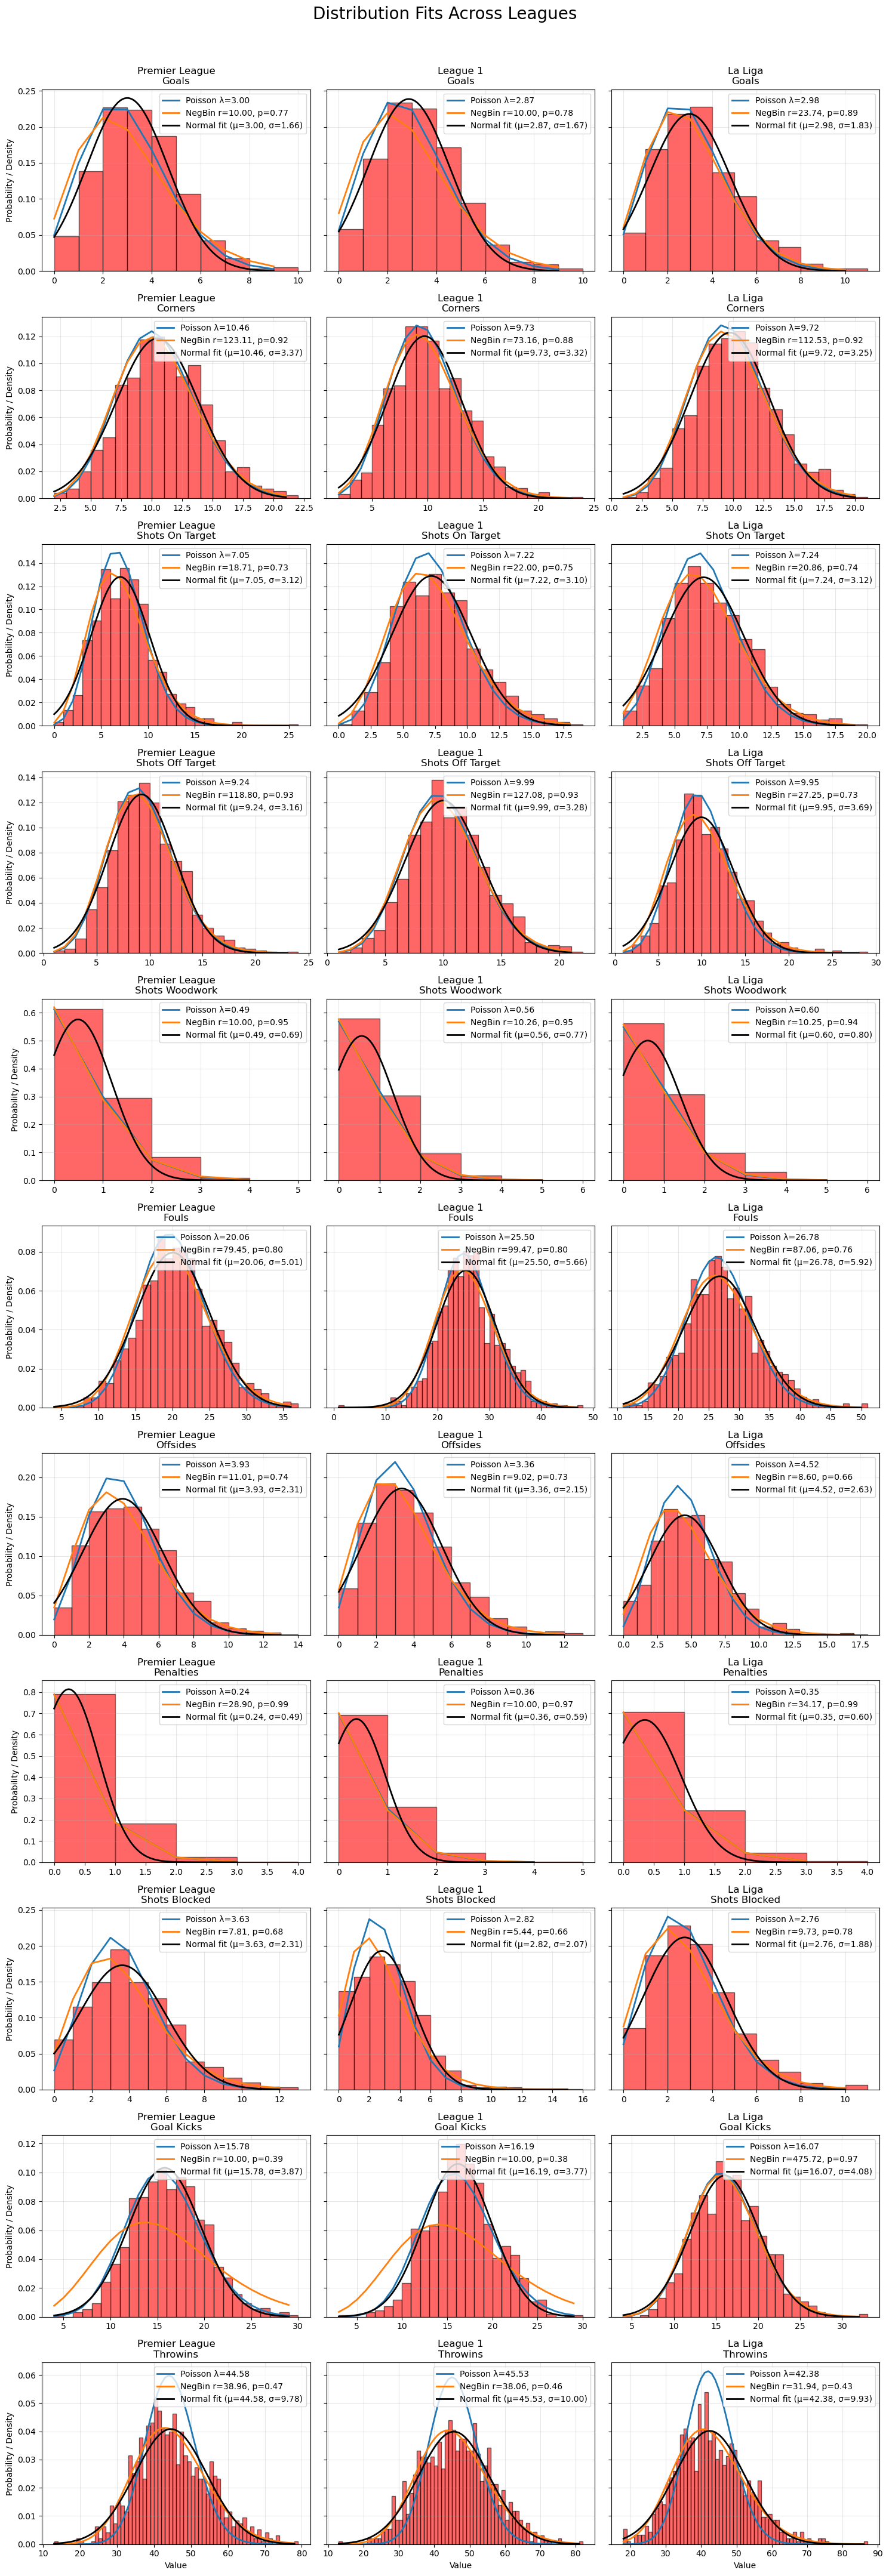

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, norm

leagues = [match_premier, match_league1, match_laliga]
labels  = ["Premier League", "League 1", "La Liga"]

stats = [
    "goals", "corners", "shots_on_target", "shots_off_target",
    "shots_woodwork", "fouls", "offsides", "penalties",
    "shots_blocked", "goal_kicks", "throwins"
]

n_stats = len(stats)
n_cols = 3  # leagues
n_rows = n_stats

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), sharey='row')
fig.suptitle("Distribution Fits Across Leagues", fontsize=20)

# Ensure axes is 2D even if only one stat
if n_rows == 1:
    axes = axes[np.newaxis, :]
if n_cols == 1:
    axes = axes[:, np.newaxis]

for i, stat in enumerate(stats):
    for j, (league, label) in enumerate(zip(leagues, labels)):
        ax = axes[i, j]
        series = pd.to_numeric(league[stat], errors="coerce").dropna().astype(int)
        if series.size == 0:
            ax.set_title(f"{label}\n{stat.replace('_',' ').title()}\n(No data)")
            ax.axis('off')
            continue

        # Empirical PMF
        k_min, k_max = int(series.min()), int(series.max())
        bins = np.arange(k_min, k_max + 2)
        weights = np.ones(series.size) / series.size
        ax.hist(series, bins=bins, align="mid", weights=weights,
                color="red", alpha=0.6, edgecolor="black")

        # Poisson
        lam = estimate_poisson_lambda(series.values)
        k_grid = np.arange(k_min, k_max + 1)
        ax.plot(k_grid, poisson_pmf(k_grid, lam), linewidth=2, label=f"Poisson λ={lam:.2f}")

        # Negative Binomial
        r, p = estimate_negbinom_params(series.values)
        ax.plot(k_grid, negbinom_pmf(k_grid, r, p), linewidth=2, label=f"NegBin r={r:.2f}, p={p:.2f}")

        # Normal
        mu, sigma = series.mean(), series.std()
        plot_gaussian_fit(series, ax)

        ax.set_title(f"{label}\n{stat.replace('_',' ').title()}", fontsize=12)
        ax.grid(True, alpha=0.3)

        # Axes labels
        if j == 0:
            ax.set_ylabel("Probability / Density")
        if i == n_rows-1:
            ax.set_xlabel("Value")

        # Show legend for this subplot
        ax.legend(loc="upper right")


# Only show legend in the first row to avoid clutter
for j in range(n_cols):
    axes[0, j].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Time evolution of league statistics and basic comparison

In [154]:
time_premier = premier_league_df.copy()
time_league1 = league1_df.copy()
time_laliga = laliga_df.copy()

time_premier["year"] = pd.to_datetime(time_premier["Timestamp"]).dt.year
time_league1["year"] = pd.to_datetime(time_league1["Timestamp"]).dt.year
time_laliga["year"] = pd.to_datetime(time_laliga["Timestamp"]).dt.year

time_premier["month"] = pd.to_datetime(time_premier["Timestamp"]).dt.month
time_league1["month"] = pd.to_datetime(time_league1["Timestamp"]).dt.month
time_laliga["month"] = pd.to_datetime(time_laliga["Timestamp"]).dt.month
years = time_premier["year"].unique().tolist()
months = time_premier["month"].unique().tolist()
print(f"Data spans across the following years: {sorted(years)}")
print(f"Data spans across the following months: {sorted(months)}")

Data spans across the following years: [2017, 2018, 2019]
Data spans across the following months: [1, 2, 3, 4, 5, 8, 9, 10, 11, 12]


In [164]:
cols = ['goals', 'shots_on_target', 'shots_off_target', 'shots_woodwork', 'corners', 'throwins', 'offsides', 'fouls']
describe_time_premier, describe_time_league1, describe_premier_laliga = [], [], []
for year in years:
    premier_year = create_descriptive_stats(time_premier[time_premier["year"] == year])
    league1_year = create_descriptive_stats(time_league1[time_league1["year"] == year])
    laliga_year = create_descriptive_stats(time_laliga[time_laliga["year"] == year])
    describe_time_premier.append(premier_year)
    describe_time_league1.append(league1_year)
    describe_premier_laliga.append(laliga_year)




C:\Users\User\AppData\Local\Temp\ipykernel_23048\3286464926.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = mask
C:\Users\User\AppData\Local\Temp\ipykernel_23048\3286464926.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = mask
C:\Users\User\AppData\Local\Temp\ipykernel_23048\3286464926.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

C:\Users\User\AppData\Local\Temp\ipykernel_23048\3692136524.py:41: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  monthly["period"] = pd.PeriodIndex(
C:\Users\User\AppData\Local\Temp\ipykernel_23048\3692136524.py:41: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  monthly["period"] = pd.PeriodIndex(
C:\Users\User\AppData\Local\Temp\ipykernel_23048\3692136524.py:41: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  monthly["period"] = pd.PeriodIndex(
C:\Users\User\AppData\Local\Temp\ipykernel_23048\3692136524.py:41: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  monthly["period"] = pd.PeriodIndex(
C:\Users\User\AppData\Local\Temp\ipykernel_23048\3692136524.py:41: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields in

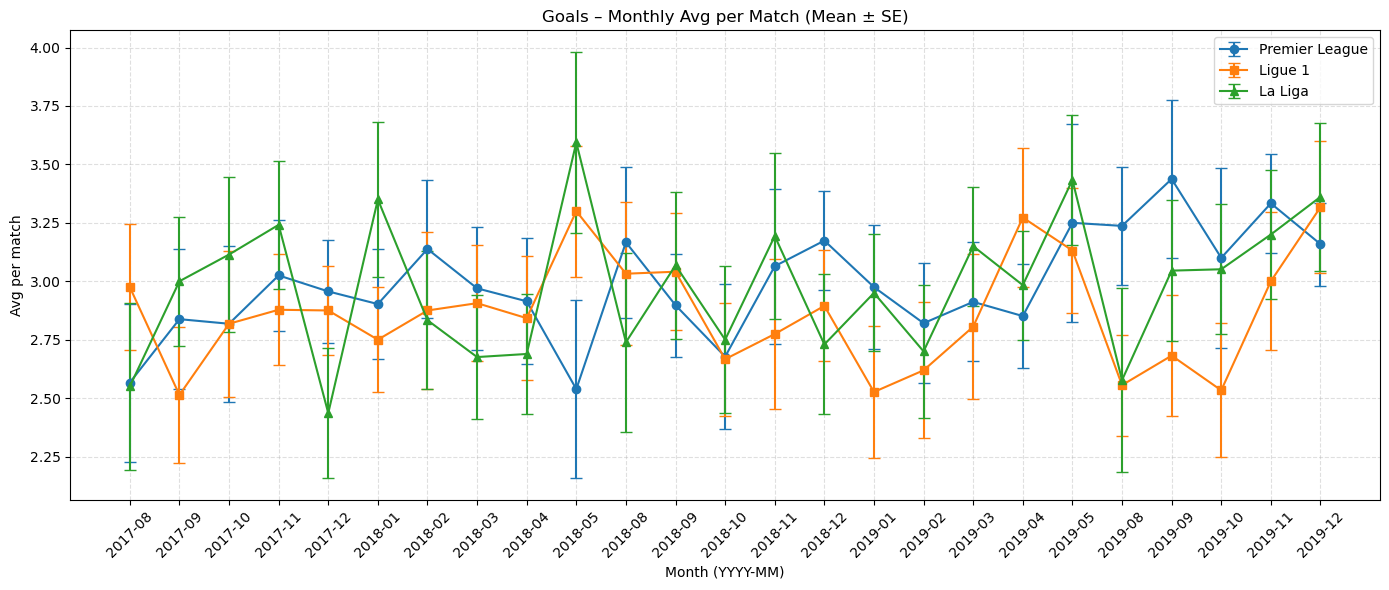

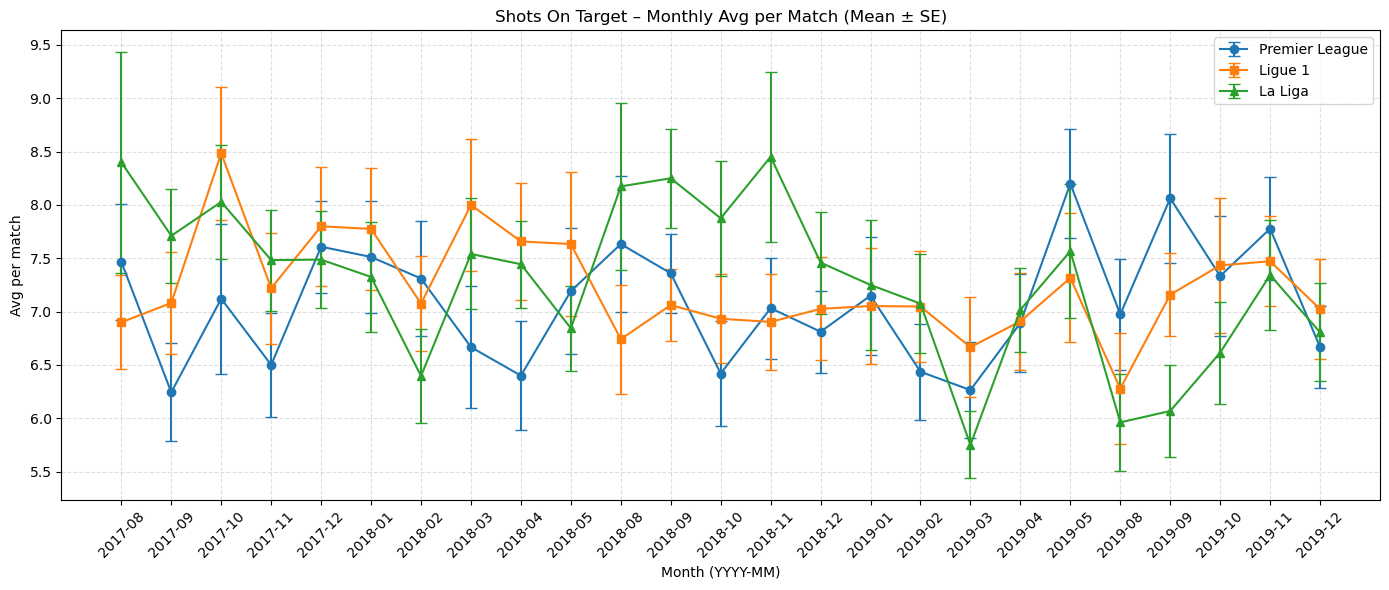

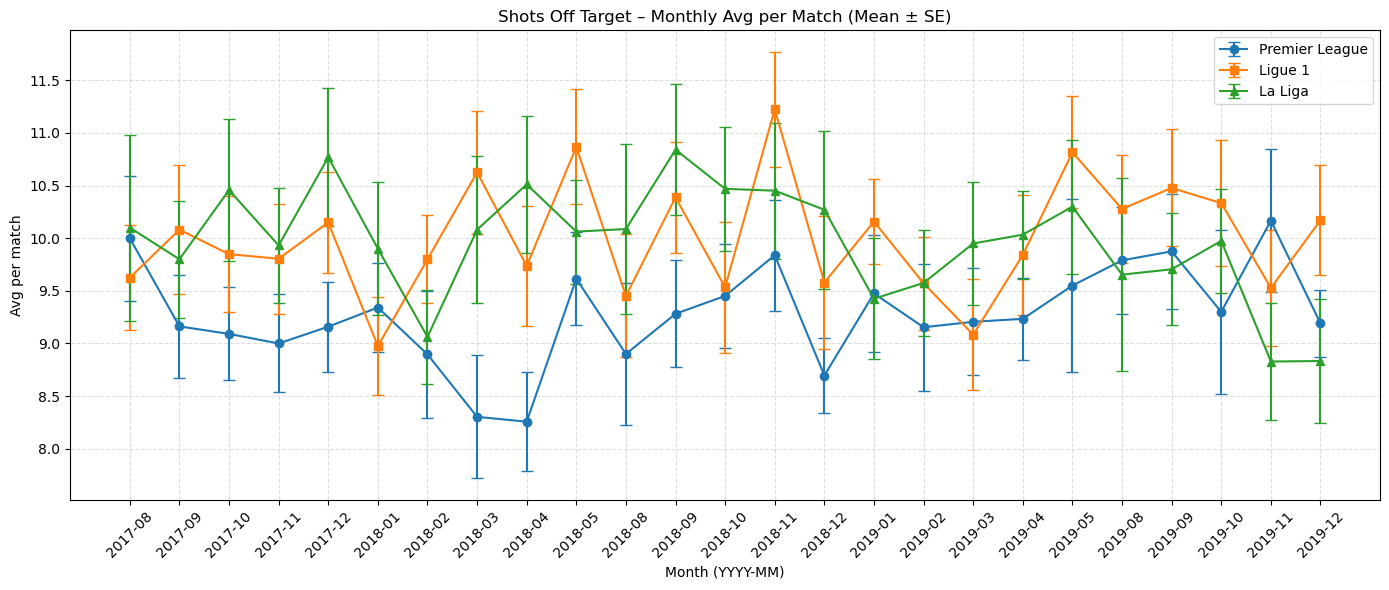

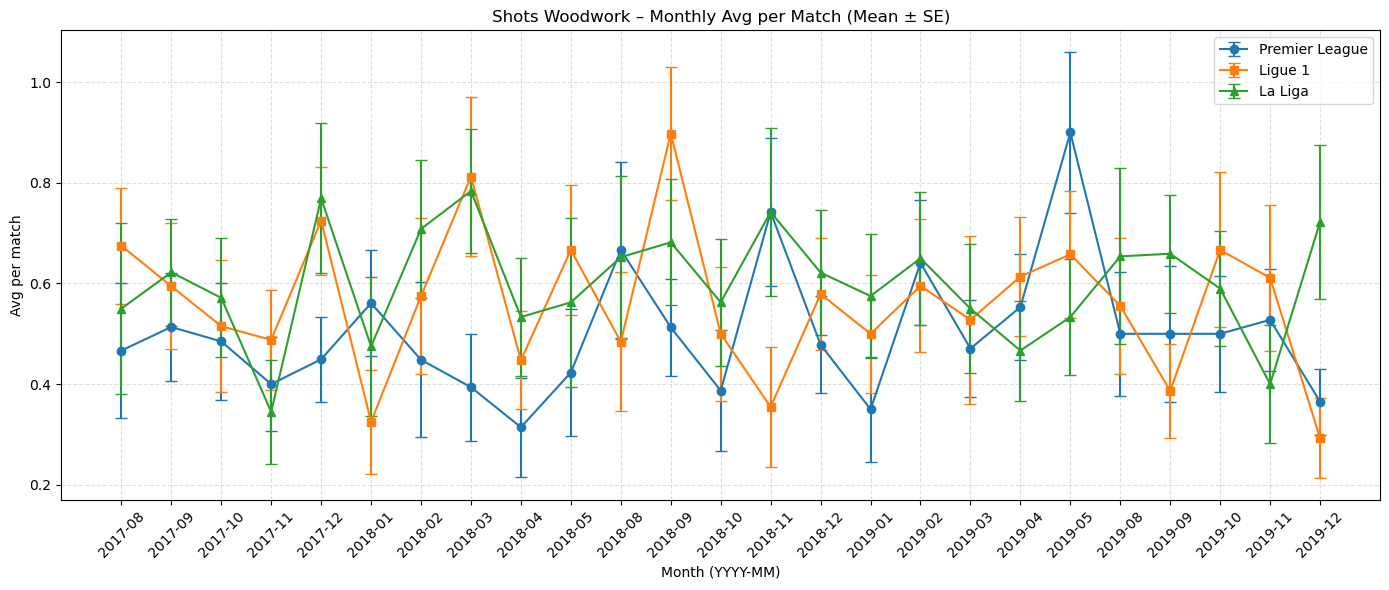

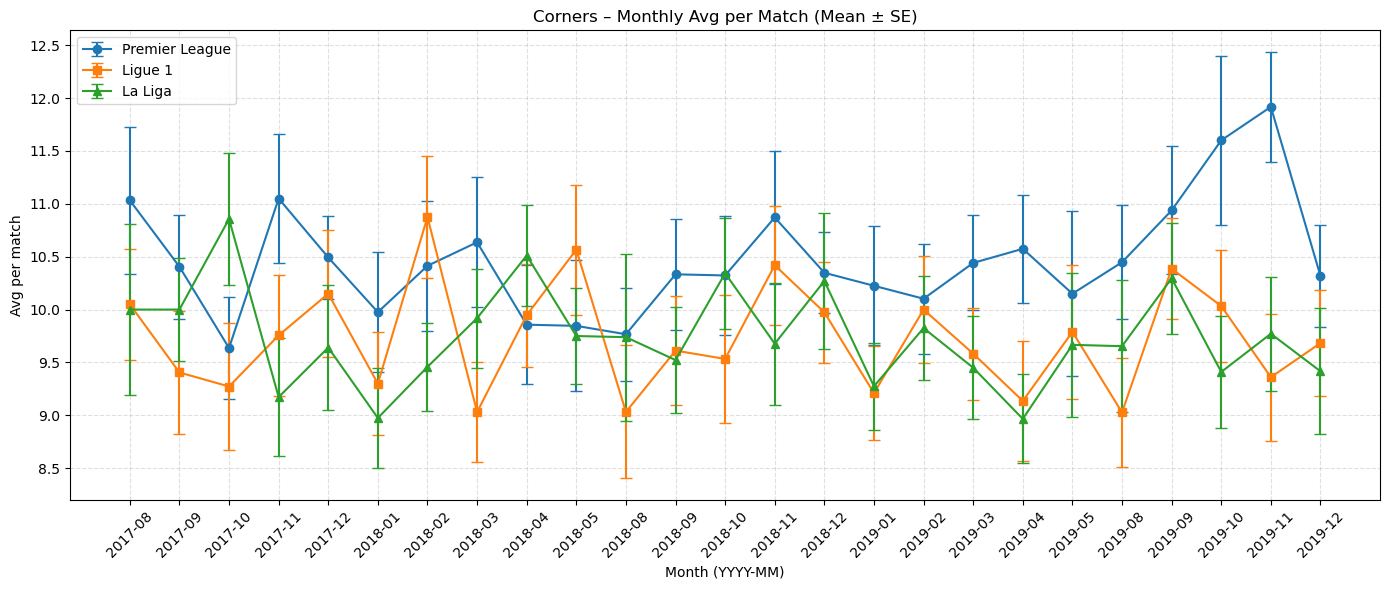

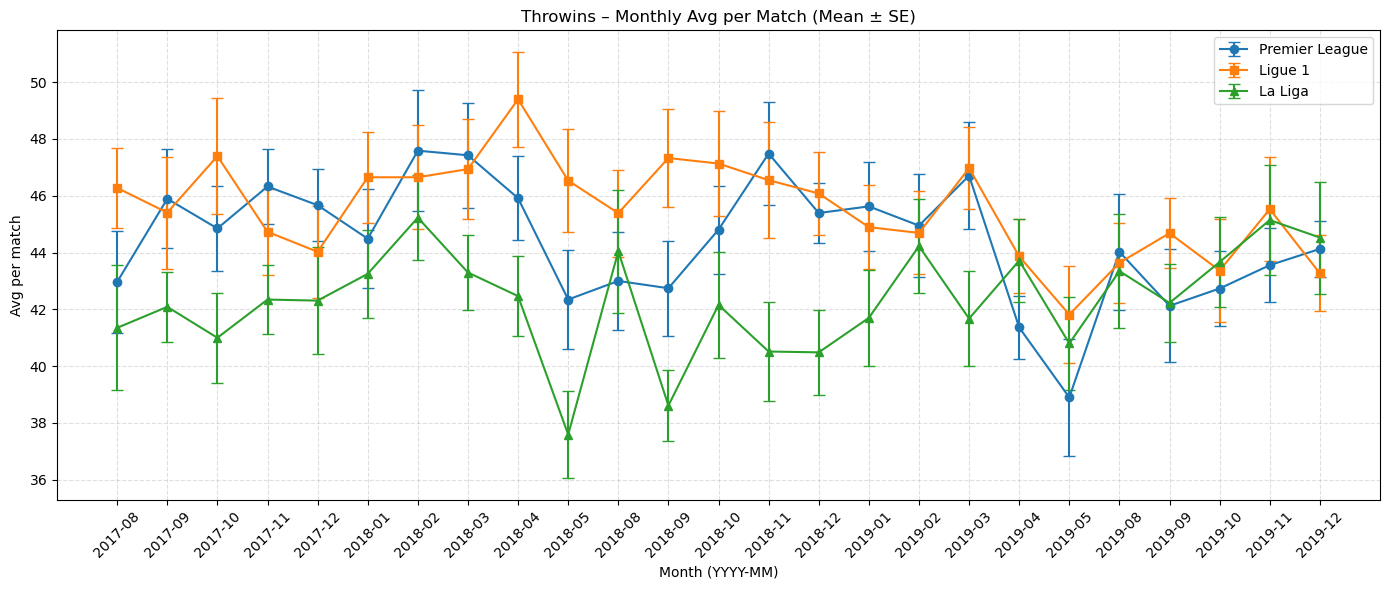

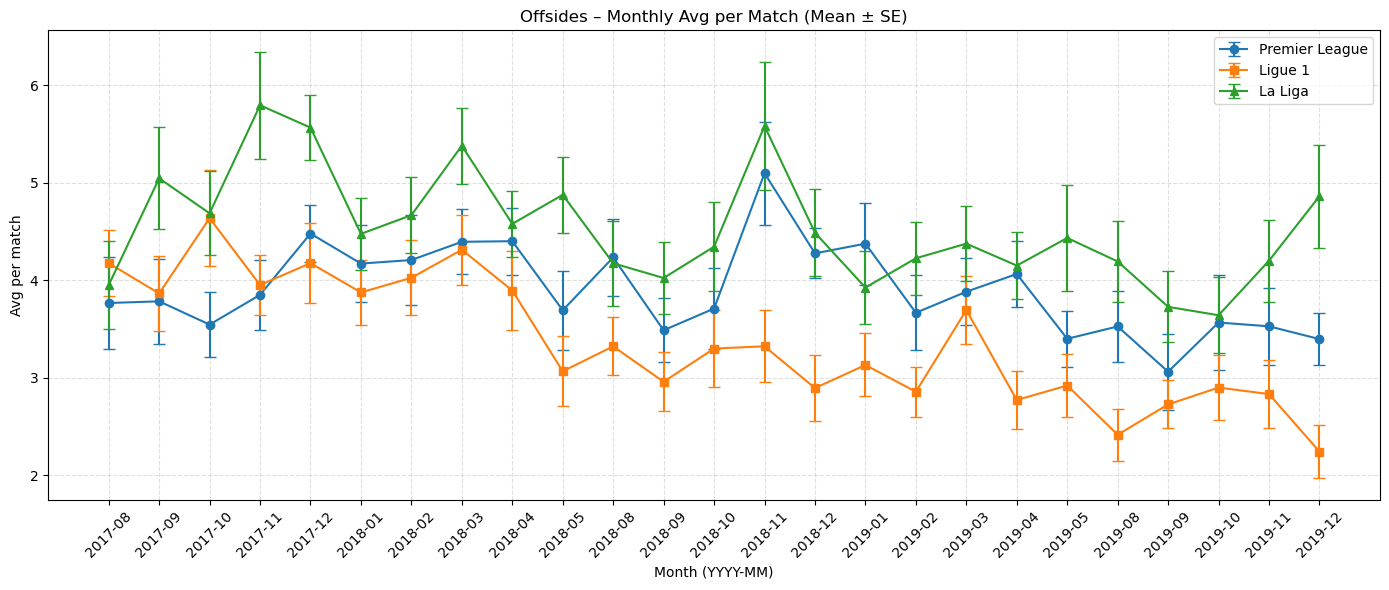

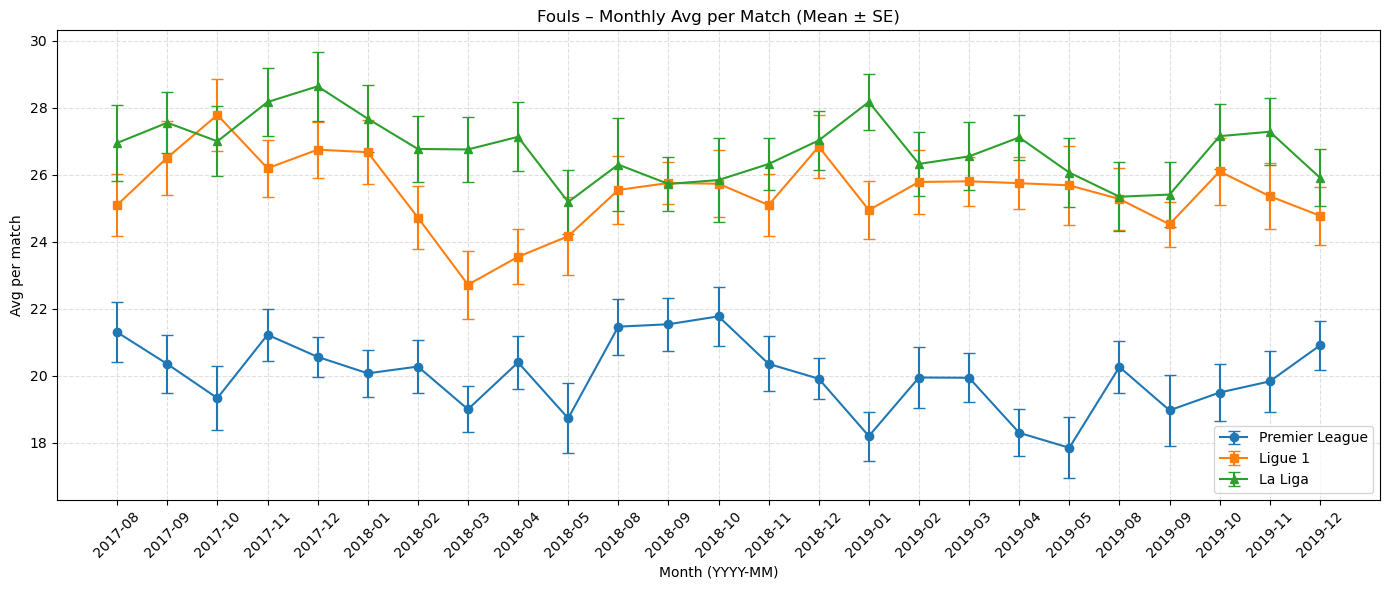

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------------------------------------
# Build monthly mean + SE per-match statistics
# -------------------------------------------------------------
def build_monthly_stats(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()
    df["year"] = pd.to_datetime(df["Timestamp"]).dt.year
    df["month"] = pd.to_datetime(df["Timestamp"]).dt.month

    # Your function that produces match-level stats
    desc, match_game = create_descriptive_stats(df)

    # Map RBallID → first timestamp (year/month)
    rb_time = (
        df.sort_values(["RBallID", "Minute"])
        .groupby("RBallID")[["year", "month"]]
        .first()
        .reset_index()
    )

    # Compute monthly mean, std, count
    monthly = (
        match_game.merge(rb_time, on="RBallID", how="left")
        .groupby(["year", "month"])
        .agg({c: ["mean", "std", "count"] for c in cols})
    )

    # Flatten MultiIndex names
    monthly.columns = ["_".join(col).rstrip("_") for col in monthly.columns]
    monthly = monthly.reset_index().sort_values(["year", "month"])

    # Standard Error = std / sqrt(n)
    for stat in cols:
        monthly[f"{stat}_se"] = monthly[f"{stat}_std"] / np.sqrt(monthly[f"{stat}_count"])

    # Period for x-axis
    monthly["period"] = pd.PeriodIndex(
        year=monthly["year"], month=monthly["month"], freq="M"
    ).astype(str)

    return monthly


# -------------------------------------------------------------
# Build monthly stats for each league
# -------------------------------------------------------------
monthly_premier = build_monthly_stats(premier_league_df)
monthly_league1 = build_monthly_stats(league1_df)
monthly_laliga = build_monthly_stats(laliga_df)


# -------------------------------------------------------------
# ONE plot per statistic, 3 leagues together
# -------------------------------------------------------------
for stat in cols:
    plt.figure(figsize=(14, 6))

    mean_col = f"{stat}_mean"
    se_col   = f"{stat}_se"

    # Premier League
    plt.errorbar(
        monthly_premier["period"],
        monthly_premier[mean_col],
        yerr=monthly_premier[se_col],
        marker="o",
        capsize=4,
        label="Premier League"
    )

    # Ligue 1
    plt.errorbar(
        monthly_league1["period"],
        monthly_league1[mean_col],
        yerr=monthly_league1[se_col],
        marker="s",
        capsize=4,
        label="Ligue 1"
    )

    # La Liga
    plt.errorbar(
        monthly_laliga["period"],
        monthly_laliga[mean_col],
        yerr=monthly_laliga[se_col],
        marker="^",
        capsize=4,
        label="La Liga"
    )

    # Title + labels
    plt.title(f"{stat.replace('_',' ').title()} – Monthly Avg per Match (Mean ± SE)")
    plt.xlabel("Month (YYYY-MM)")
    plt.ylabel("Avg per match")

    # Rotate x labels
    plt.xticks(rotation=45)

    # Grid + legend
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()

    plt.tight_layout()
    plt.show()


## Leaderboard determination for each season and League

# Check performance of top 10 teams in the leaderboard

* Define Start and End of a season
* Introduce horizontal barcharts for those teams with home/away stats

In [188]:
premier_league_df.head()

RBallID    HomeTeam           AwayTeam            Timestamp  \
14   849137  Arsenal FC  Leicester City FC  08/11/2017 18:45:52   
15   849137  Arsenal FC  Leicester City FC  08/11/2017 18:45:54   
16   849137  Arsenal FC  Leicester City FC  08/11/2017 18:46:02   
17   849137  Arsenal FC  Leicester City FC  08/11/2017 18:46:11   
18   849137  Arsenal FC  Leicester City FC  08/11/2017 18:46:13   

            Incident  IncidentNumber  Minute  
14  Start RT1 Team 1              14       1  
15             SAFE1              15       1  
16               AT1              16       1  
17             SAFE1              17       1  
18               AT1              18       1

In [213]:
def assign_season(dt):
    year = dt.year
    month = dt.month
    return f"{year}-{year+1}" if month >= 8 else f"{year-1}-{year}"


def create_formatted_games_df(df: pd.DataFrame):
    """
    Build per-match aggregated statistics AND a leaderboard per season.
    Returns:
        aggregated (DataFrame): per-match stats
        leaderboards_per_season (dict): {season: leaderboard_df}
    """

    # ------------------------------------------
    # 1. Define all stats based on incidents
    # ------------------------------------------
    stats = {
        "Home Goals": (df["Incident"] == "GOAL1"),
        "Away Goals": (df["Incident"] == "GOAL2"),
        "Home Corners": (df["Incident"] == "CR1"),
        "Away Corners": (df["Incident"] == "CR2"),
        "Home Shots on Target": (df['Incident'] == 'SHG1'),
        "Away Shots on Target": (df['Incident'] == 'SHG2'),
        "Home Fouls": (df['Incident'] == 'F1'),
        "Away Fouls": (df['Incident'] == 'F2'),
        "Home Offsides": (df['Incident'] == 'O1'),
        "Away Offsides": (df['Incident'] == 'O2'),
        "Home Penalties": (df['Incident'] == 'PEN1'),
        "Away Penalties": (df['Incident'] == 'PEN2'),
        "Home Shots Blocked": (df['Incident'] == 'BLOCKED1'),
        "Away Shots Blocked": (df['Incident'] == 'BLOCKED2'),
        "Home Goal Kicks": (df['Incident'] == 'GK1'),
        "Away Goal Kicks": (df['Incident'] == 'GK2'),
        "Home Shots off Target": (df['Incident'] == 'SHB1'),
        "Away Shots off Target": (df['Incident'] == 'SHB2'),
        "Home Throwins": (df['Incident'] == 'TI1'),
        "Away Throwins": (df['Incident'] == 'TI2'),
        "Home Shots Woodwork": (df['Incident'] == 'SHW1'),
        "Away Shots Woodwork": (df['Incident'] == 'SHW2'),
    }

    # ------------------------------------------
    # 2. Assign Season
    # ------------------------------------------
    df["Season"] = pd.to_datetime(df["Timestamp"]).apply(assign_season)

    # ------------------------------------------
    # 3. Convert incident masks to numeric
    # ------------------------------------------
    for name, mask in stats.items():
        df[name] = mask.astype(int)

    # ------------------------------------------
    # 4. Aggregate per match
    # ------------------------------------------
    agg_cols = list(stats.keys())
    aggregated = df.groupby(
        ["RBallID", "HomeTeam", "AwayTeam", "Season"]
    )[agg_cols].sum().reset_index()

    # ------------------------------------------
    # 5. Compute match result (H/A/D)
    # ------------------------------------------
    conditions = []
    for _, row in aggregated.iterrows():
        if row["Home Goals"] > row["Away Goals"]:
            conditions.append("H")
        elif row["Home Goals"] < row["Away Goals"]:
            conditions.append("A")
        else:
            conditions.append("D")

    aggregated["Result"] = conditions

    # ------------------------------------------
    # 6. Build Leaderboard for each Season
    # ------------------------------------------

    leaderboards_per_season = {}

    for season, df_season in aggregated.groupby("Season"):
        rows = []

        for _, row in df_season.iterrows():
            home = row["HomeTeam"]
            away = row["AwayTeam"]
            hg = row["Home Goals"]
            ag = row["Away Goals"]
            result = row["Result"]

            # Assign points
            if result == "H":
                home_points, away_points = 3, 0
            elif result == "A":
                home_points, away_points = 0, 3
            else:
                home_points, away_points = 1, 1

            # Append both teams
            rows.append([season, home, home_points, hg, ag])
            rows.append([season, away, away_points, ag, hg])

        # Create DataFrame for this season
        season_df = pd.DataFrame(rows, columns=[
            "Season", "Team", "Points", "GoalsFor", "GoalsAgainst"
        ])

        # Aggregate leaderboard
        leaderboard = season_df.groupby(["Season", "Team"]).agg(
            TotalPoints=("Points", "sum"),
            GoalsFor=("GoalsFor", "sum"),
            GoalsAgainst=("GoalsAgainst", "sum"),
        ).reset_index()

        leaderboard["GoalDifference"] = (
            leaderboard["GoalsFor"] - leaderboard["GoalsAgainst"]
        )

        leaderboard = leaderboard.sort_values(
            ["Season", "TotalPoints", "GoalDifference"],
            ascending=[True, False, False]
        )

        leaderboards_per_season[season] = leaderboard.reset_index(drop=True)

    # ------------------------------------------
    # 7. Return results
    # ------------------------------------------
    return aggregated, leaderboards_per_season
aggregated_premier, leaderboards_premier = create_formatted_games_df(premier_league_df)


In [214]:
aggregated_premier.head()

RBallID           HomeTeam              AwayTeam     Season  Home Goals  \
0   849137         Arsenal FC     Leicester City FC  2017-2018           4   
1   849138         Watford FC          Liverpool FC  2017-2018           3   
2   849139         Chelsea FC            Burnley FC  2017-2018           3   
3   849140  Crystal Palace FC  Huddersfield Town FC  2017-2018           0   
4   849141         Everton FC         Stoke City FC  2017-2018           1   

   Away Goals  Home Corners  Away Corners  Home Shots on Target  \
0           3             9             4                     6   
1           3             3             3                     2   
2           4             8             5                    10   
3           3            12             9                     3   
4           0             6             7                     3   

   Away Shots on Target  ...  Away Shots Blocked  Home Goal Kicks  \
0                     1  ...                   0                6   
1                     2  ...                   1               12   
2                     2  ...                   1                4   
3                     4  ...                   0                3   
4                     2  ...                   2               10   

   Away Goal Kicks  Home Shots off Target  Away Shots off Target  \
0               12                     10                      2   
1                7                      2                      7   
2               10                      7                      3   
3               10                      7                      2   
4                8                      3                      4   

   Home Throwins  Away Throwins  Home Shots Woodwork  Away Shots Woodwork  \
0             21             32                    0                    0   
1             27             27                    0                    1   
2             12              8                    0                    1   
3             19             29                    0                    0   
4             25             28                    0                    0   

   Result  
0       H  
1       D  
2       A  
3       A  
4       H  

[5 rows x 27 columns]